# Clustering: K-Means In-Depth

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Introducing K-Means

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

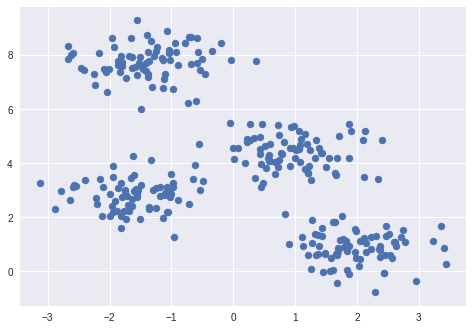

In [18]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

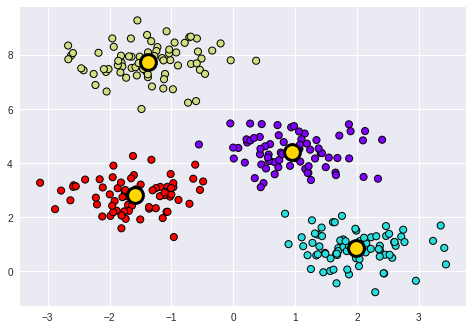

In [19]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow',edgecolor='black', linewidth=1);
plt.scatter(est.cluster_centers_[:,0], est.cluster_centers_[:,1], s=250, color="gold", edgecolor='black', linewidth=3); # Show the centres

The clusterization is of course learned and adapted on the dataset but it also create a partition of the space. If we somehow obtain a new data point we can still know to which cluster it belongs, we do not need to re-run the clustering procedure

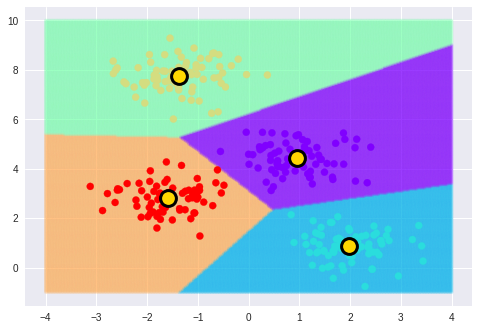

In [20]:
gx = np.linspace(-4, 4, 256)                         # procedure to create two vector that contain the x and the y of the 256x256 points that fill the space 
gy = np.linspace(-1, 10, 256)                            # ranging from x=(-4.5 to 4.5) and y=(-3 to 11)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)

y_hat = est.predict(np.c_[gx, gy])                           #np.c creates a Nx2 matrix from two N lenght vectors
plt.scatter(gx, gy, c=plt.cm.rainbow(y_hat / 4), alpha=0.2, s=10)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');
plt.scatter(est.cluster_centers_[:,0], est.cluster_centers_[:,1], s=250, color="gold", edgecolor='black', linewidth=3); # Show the centres

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
   A. Assign points to the nearest cluster center
   B. Set the cluster centers to the mean 
   
Let's quickly visualize this process:

https://user.ceng.metu.edu.tr/~akifakkus/courses/ceng574/k-means/  

(put distribution 2 and 3 clusters)

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()

In [22]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

(10, 64)

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

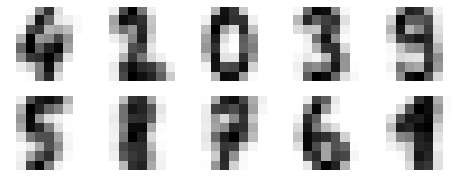

In [23]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])                     # 2x5 is the  shape of the total plot, xtiks=[] and ytiks=[] ensures  
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)      # that nothing is written on the axis and that there are no gridlines

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [24]:
from scipy.stats import mode

labels = np.zeros_like(clusters)                     # np.zeros_like copies the shape of the given array
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]    #at each point belonging to cluster "i" we assign the same label as the mode of the number they represent
                  


For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

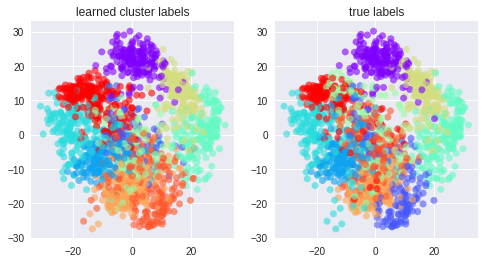

In [25]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10) ,edgecolor='none', alpha=0.6)   #call the same thing in each plot

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7918753478018921

80% – not bad! Let's check-out the confusion matrix for this:

[[177   0   0   0   1   0   0   0   0   0]
 [  0  54  24   1   0   1   2   0 100   0]
 [  1   2 147  13   0   0   0   4   8   2]
 [  0   0   1 157   0   2   0   7   7   9]
 [  0   3   0   0 165   0   0  11   2   0]
 [  0   0   0   1   2 129   1   0   0  49]
 [  1   0   0   0   0   0 177   0   3   0]
 [  0   2   0   0   0   0   0 175   2   0]
 [  0   6   3   2   0   4   2   5 102  50]
 [  0  20   0   6   0   4   0   9   1 140]]


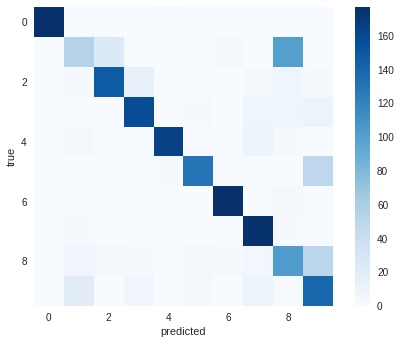

In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Again, this is an 80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

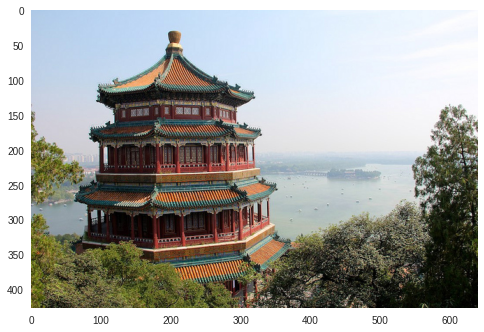

In [28]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [29]:
print(china.shape)
print('the RGB of the pixel [3,4] is ',china[3,4,:])

(427, 640, 3)
the RGB of the pixel [3,4] is  [174 201 231]


We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [30]:
X = (china / 255.0).reshape(-1,3)     #"-1" means all the rows necessary
print(X.shape)

(273280, 3)


We now have 273,280 points in 3 dimensions.

Each of the 273,280 pixel has a color represented with three numbers from 0 to 255. In image processing this is called "24 bit per pixel" (bpp) since you need exactly 24 bits of memory for storing the 3 colors on the pixel ($256^3=2^{24}$).

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say 64 colors that is 6 bpp, a commonly used compression method for images). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

Here we'll use ``MiniBatchKMeans``, a more sophisticated estimator that performs better for larger datasets:

In [31]:
from sklearn.cluster import MiniBatchKMeans   # the iteration of K means are done on random sub-sets to speed up the computation

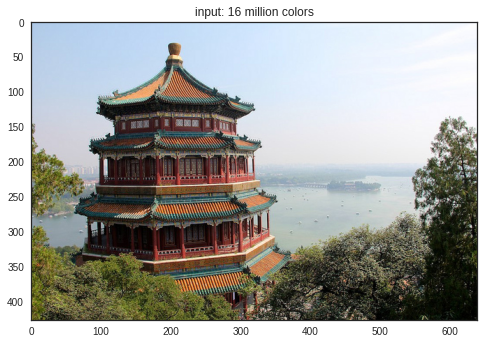

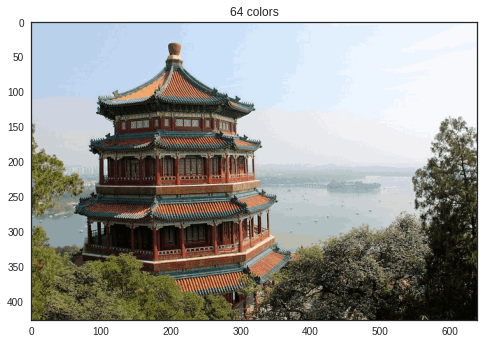

In [32]:
# reduce the size of the image for speed
n_colors = 64                                     # what happend if you put 2? that is 1 bpp

X = (china / 255.0).reshape(-1, 3)
    
model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with plt.style.context('seaborn-white'):
    plt.figure()
    plt.imshow(china)
    plt.title('input: 16 million colors')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just $64$ ($4^3$).

# How to decide the number of clusters?

With the blobs it is evident that we had 4 different clusters, with the digits we already know that we have 10 numbers and with the colors we have the reference of the image-compressing techniques.
How do we do if we do not have any reference?
A possible strategy is to make sure that our clusters are built on data proprierties. One possible way to do so is to partition the dataset in two and then check what happens as we increase the number of clusters:

In [34]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)


def try_N_clusters(N):
  model_1 = KMeans(N)  # N clusters
  model_1.fit(X[0:150,:])
  y_model_1 = model_1.predict(X)
  model_2 = KMeans(N)  # N clusters
  model_2.fit(X[150:,:])
  y_model_2 = model_2.predict(X)
                  
  fig, ax = plt.subplots(1, 2, figsize=(14, 5))
  ax[0].scatter(X[:, 0], X[:, 1], c=y_model_1, s=50, cmap='rainbow')
  ax[0].set_title('clusters learned on first half')

  ax[1].scatter(X[:, 0], X[:, 1], c=y_model_2, s=50, cmap='rainbow')
  ax[1].set_title('tclusters learned on second half');


from ipywidgets import interact
interact(try_N_clusters, N=(1, 7));

interactive(children=(IntSlider(value=4, description='N', max=7, min=1), Output()), _dom_classes=('widget-inte…

It is clear that when we go over 5 clusters we start to adapt to the noise in the data since the division is not coherent between the two partitions.

# How can we choose the right clustering algorithm?






The best clustering algorithm to use depends on the dataset that we have. If the data is low dimensioanl it is easy to visually check what going on during the clustering but, arguably, those are the cases where the application of those techniques is not so useful. 
There is no definitive answer on what algorithm you should choose in a given situation but there are some tips:



*   **Try several algorithms** : if the cluster division does not differ too much between different techniques probably you do not need to stress too much about the selection.
*   **Make the data low dimensional** : if you are able to visualize the data in a low dimensional space you are also able to check if the clusters make sense (usually we do not like to have delocalized clusters). It is a good thing when the dimensionality-reduction and the clustering algorithm are coehrent since the choice of both is somehow justified.
* **Are cluster centers representative?** : can you somehow approximate the points in a cluster with the center? If yes, chances are that you are good to go.



Here we have a reference on the application of the most common clustering techniques to different types of datasets. We can clearly see that, depending on the situation, some techniques are more suited than the others.

https://miro.medium.com/max/1200/1*oNt9G9UpVhtyFLDBwEMf8Q.png

# Density Estimation: Gaussian Mixture Models

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

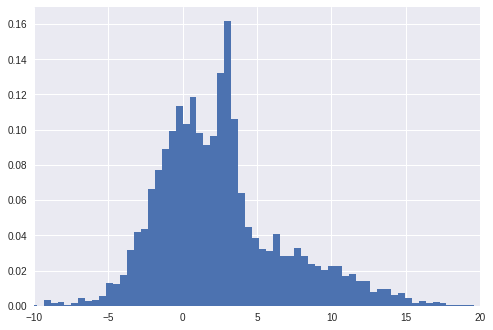

In [36]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])     # concatenates the three gaussian-distributed vectors
x=x.reshape(-1,1)

plt.hist(x, 80, density=True)                          # density=True normalizes the histogram
plt.xlim(-10, 20);

\Gaussian mixture models will allow us to approximate this density, let's try with 4 gaussians:

In [37]:
from sklearn.mixture import GaussianMixture as GMM
clf = GMM(4, max_iter=500, random_state=3).fit(x)



In [38]:
xpdf = np.linspace(-10, 20, 1000)                                    # define the x_axis for the plots
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])       # creation of a vector with the for cycle. clf.score[x] is the log prob of the 
                                                                     # learned gaussian mixture in point x

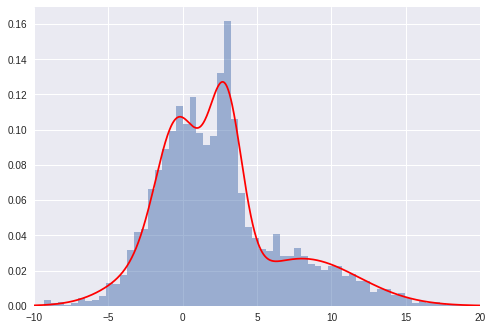

In [39]:
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, c='red')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [40]:
clf.means_

array([[-1.762037  ],
       [ 8.04894855],
       [ 2.87628921],
       [-0.26509542]])

In [41]:
clf.covariances_

array([[[ 7.39304484]],

       [[14.2611261 ]],

       [[ 1.25253655]],

       [[ 2.1852085 ]]])

In [42]:
clf.weights_

array([0.15154409, 0.2532411 , 0.28492403, 0.31029078])

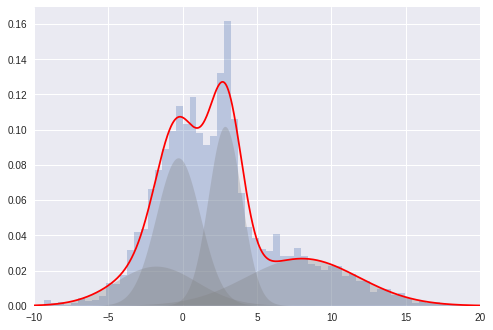

In [43]:
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, c='red')

for i in range(4):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)     # stats.norm(mean, dev_st).pdf(x_axis) creates a vector
    plt.fill(xpdf, pdf, facecolor='gray',                                             # evaluating the density of the gaussian in all the points of x_axis
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method, much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.
Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

$$AIC = -2*log\big(P(Data)\big) + 2*K$$

$$BIC = -2*log\big(P(Data)\big) + log(n)*K$$

Both scores have a penalty in the number of parameters $K$. This penalty is fixed in the AIC and scales with the numbers of data-points in the BIC.

In [141]:
print(clf.bic(x))
print(clf.aic(x))

25825.201910224507
25754.42998281726


Let's take a look at these as a function of the number of gaussians:

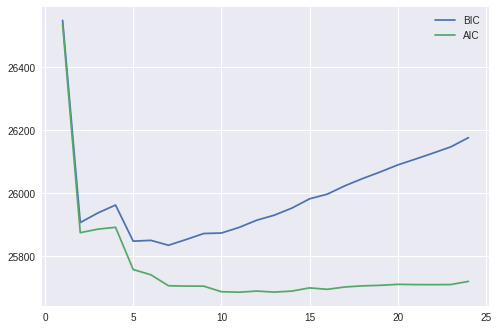

In [144]:
n_estimators = np.arange(1, 25)
clfs = [GMM(n, max_iter=1000, random_state= 30).fit(x) for n in n_estimators]     # method to create a list of models
bics = [clf.bic(x) for clf in clfs] 
aics = [clf.aic(x) for clf in clfs]

plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();

# Disclaimer: in Sklearn formulation the lower are AIC and BIC scores the better.

Normally you look at the position of the elbow of those curves. Here it seems to be between 2 and 6 so ~4 is a good choice. We know that we generated the data with 3 gaussians, those procedure are good but not perfect...





## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.
One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model; the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [45]:
np.random.seed(0)
# Add 20 outliers
true_outliers = np.random.randint(0, x.shape[0], 20)  # generate 20 random numbers between 0 and len(x)
y = x.reshape(-1)
y[true_outliers] += 50 * np.random.randn(20)               # we make those number outliers randomly modifying their value 
y=y.reshape(-1,1)


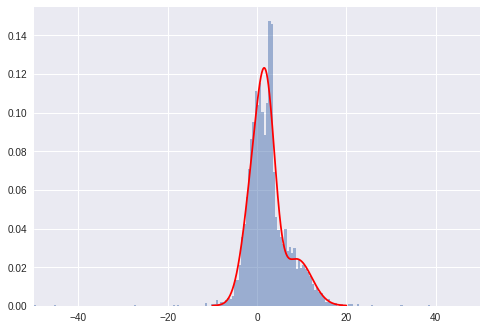

In [49]:
clf = GMM(4, max_iter=500, random_state=0).fit(y)                   # Here we build a model with the "dirty" data. We use 4 
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

plt.hist(y, 300, density=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-50, 50);

Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

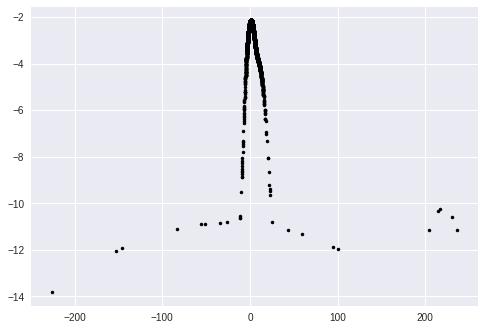

In [165]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y.reshape(-1)])
plt.plot(y, log_likelihood, '.k');  #log lokelyhood of the dirty points against their value

In [168]:
detected_outliers = np.where(log_likelihood < -10)[0]   #find the index of the points with the condition

print("true outliers:")
print(np.sort(true_outliers))
print("\ndetected outliers:")
print(np.sort(detected_outliers))

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  705 1033 1653 1701 2046 2135 2163 2222 2496 2599 2607 2732 2893
 2897 3067 3173 3253 3264 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [50]:
set(true_outliers) - set(detected_outliers)   # elements in true_outliers but not in detected_outliers

NameError: ignored

And here are the non-outliers which were spuriously labeled outliers:

In [171]:
set(detected_outliers) - set(true_outliers)   # elements in detected_outliers but not in detected_outliers

{3067, 3173, 3253, 3483}

Outlier detection is a very important tool. For example it is used to detect real time anomalies during flights. That is a very serious task...